In [1]:
%%capture
# !pip install -q torch torchvision matplotlib pillow
! pip install segmentation_models_pytorch
import os
import json
import time
import random
import numpy as np
import pandas as pd

# Image processing
from PIL import Image, ImageDraw
import skimage.io as io

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as T
from pycocotools.coco import COCO
import segmentation_models_pytorch as smp

In [ ]:
# # extract the zip folder
# %%capture
# !unzip "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images"

In [2]:
# load the training images
train_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/train-300/data"
train_annotation = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/train-300/labels.json"
val_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/validation-300/data"
val_annotation = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/validation-300/labels.json"
test_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/test-30"
coco = COCO(train_annotation)

loading annotations into memory...
Done (t=1.56s)
creating index...
index created!


Exploratory Data Analysis

In [ ]:
# Get the categories IDs
category_IDs = coco.getCatIds()
categories = coco.loadCats(category_IDs)
print(categories)

[{'id': 0, 'name': 'airplane', 'supercategory': 'vehicle'}, {'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}, {'id': 2, 'name': 'banana', 'supercategory': 'food'}, {'id': 3, 'name': 'baseball bat', 'supercategory': 'sports'}, {'id': 4, 'name': 'baseball glove', 'supercategory': 'sports'}, {'id': 5, 'name': 'bear', 'supercategory': 'animal'}, {'id': 6, 'name': 'bench', 'supercategory': 'outdoor'}, {'id': 7, 'name': 'bicycle', 'supercategory': 'vehicle'}, {'id': 8, 'name': 'bird', 'supercategory': 'animal'}, {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}, {'id': 10, 'name': 'book', 'supercategory': 'indoor'}, {'id': 11, 'name': 'bottle', 'supercategory': 'kitchen'}, {'id': 12, 'name': 'bowl', 'supercategory': 'kitchen'}, {'id': 13, 'name': 'broccoli', 'supercategory': 'food'}, {'id': 14, 'name': 'bus', 'supercategory': 'vehicle'}, {'id': 15, 'name': 'cake', 'supercategory': 'food'}, {'id': 16, 'name': 'car', 'supercategory': 'vehicle'}, {'id': 17, 'name': 'carrot', 'sup

In [ ]:
names_cats = [cats["name"] for cats in categories]
print(len(names_cats), "COCO categories:", " ".join(names_cats))

names_scats = set([cats["supercategory"] for cats in categories])
print(len(names_scats), "COCO supercategories:", " ".join(names_scats))

63 COCO categories: airplane backpack banana baseball bat baseball glove bear bench bicycle bird boat book bottle bowl broccoli bus cake car carrot cat cell phone chair clock cow cup dining table dog donut elephant fire hydrant fork frisbee giraffe handbag horse hot dog kite knife laptop motorcycle oven parking meter person pizza potted plant refrigerator remote sandwich scissors skateboard skis spoon sports ball stop sign suitcase surfboard tennis racket tie traffic light train truck umbrella vase wine glass
12 COCO supercategories: electronic food person kitchen appliance indoor sports vehicle furniture accessory animal outdoor


In [ ]:
# Function to get the category name
def get_category_name(class_ID, categories):
    for i in range(len(categories)):
        if categories[i]["id"] == class_ID:
            return categories[i]["name"]
    return "None"

In [ ]:
# Print category name
category_name_16 = get_category_name(16, categories)
print(f"The category name is {category_name_16}.")

The category name is car.


In [ ]:
# Print the category and number of images in specific classes.
filter_classes = ["car","cake","person","dog"]

for filter_class in filter_classes:
    category_IDs = coco.getCatIds(catNms=filter_class)
    image_IDs = coco.getImgIds(catIds=category_IDs)
    print(f"Number of images containing {filter_class}: {len(image_IDs)}.")
    print(f"IDs of images containing specified category(ies): {image_IDs}.")

Number of images containing car: 283.
IDs of images containing specified category(ies): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,

<ipython-input-8-1180074752>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_img_df.head(20), x="Category", y="Image Count", palette="viridis")


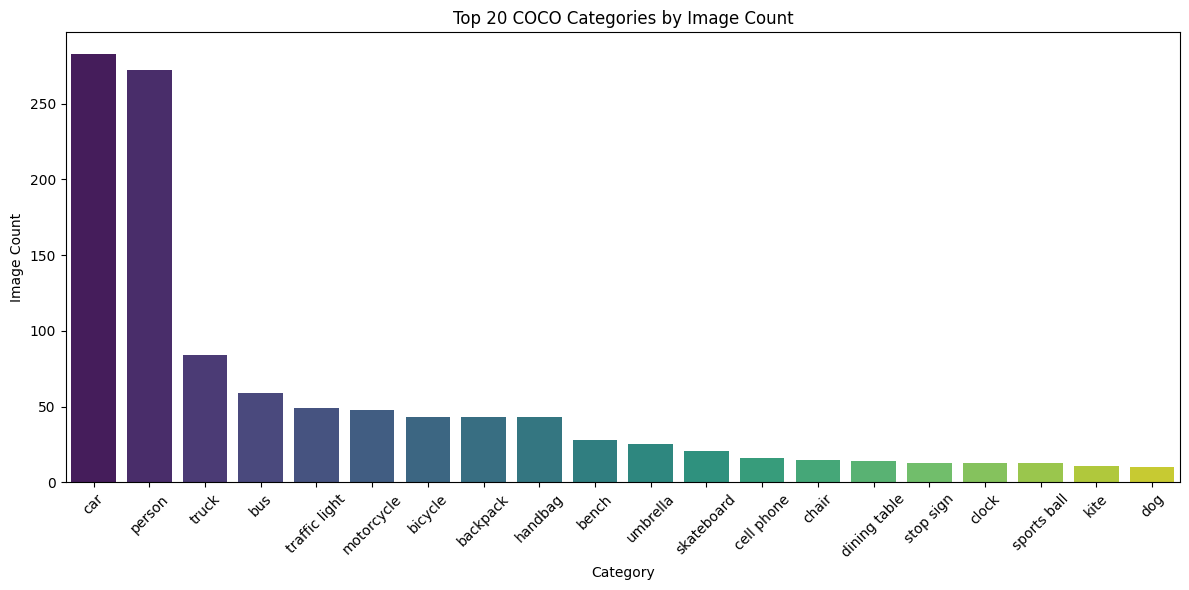

In [ ]:
# Get all categories
cats = coco.loadCats(coco.getCatIds())
cat_names = [cat['name'] for cat in cats]
cat_ids = coco.getCatIds()

# Count number of images per category
cat_img_count = {cat['name']: len(coco.getImgIds(catIds=cat['id'])) for cat in cats}
cat_img_df = pd.DataFrame(list(cat_img_count.items()), columns=["Category", "Image Count"])
cat_img_df = cat_img_df.sort_values("Image Count", ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=cat_img_df.head(20), x="Category", y="Image Count", palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 20 COCO Categories by Image Count")
plt.tight_layout()
plt.show()

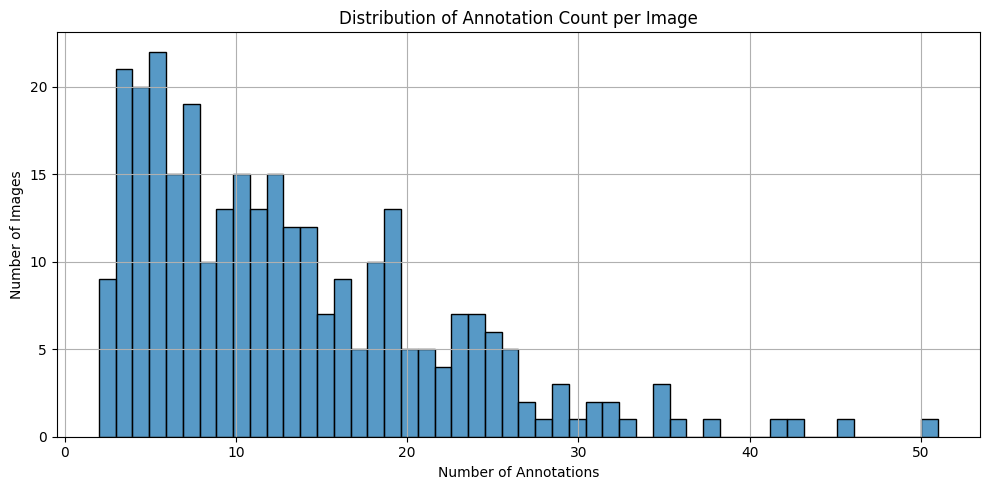

In [ ]:
ann_count = {}
for img_id in coco.getImgIds():
    ann_ids = coco.getAnnIds(imgIds=img_id)
    ann_count[img_id] = len(ann_ids)

ann_count_series = pd.Series(ann_count)
plt.figure(figsize=(10,5))
sns.histplot(ann_count_series, bins=50, kde=False)
plt.title("Distribution of Annotation Count per Image")
plt.xlabel("Number of Annotations")
plt.ylabel("Number of Images")
plt.grid(True)
plt.tight_layout()
plt.show()

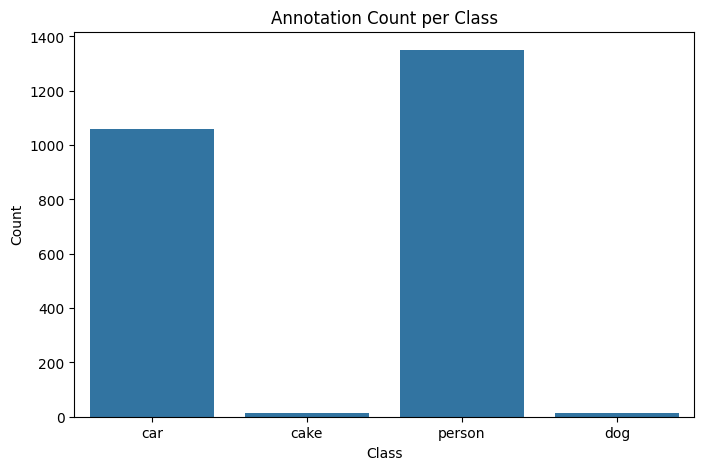

In [ ]:
class_counts = {}

for cls in filter_classes:
    cat_ids = coco.getCatIds(catNms=[cls])
    ann_ids = coco.getAnnIds(catIds=cat_ids)
    class_counts[cls] = len(ann_ids)

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Annotation Count per Class")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

{'id': 32, 'file_name': '000000002754.jpg', 'height': 480, 'width': 640, 'license': None, 'coco_url': None}


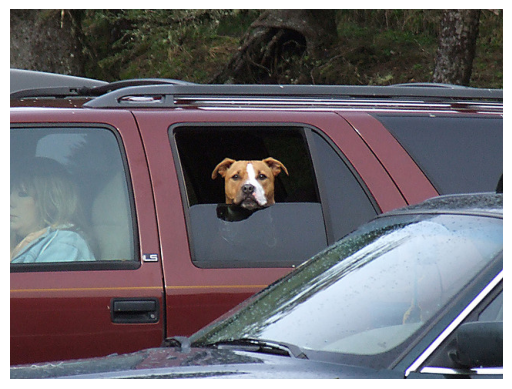

In [ ]:
# Print and example Image
example_image = coco.loadImgs(image_IDs[0])[0]
print(example_image)
image = io.imread(f'{train_data_path}/{example_image["file_name"]}')
plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# Print the annotation IDs
test_image_annotations_ID = coco.getAnnIds(
    imgIds=example_image["id"], catIds=category_IDs, iscrowd=None
)
print(test_image_annotations_ID)


test_image_annotations = coco.loadAnns(test_image_annotations_ID)
print(test_image_annotations)

[353]
[{'id': 353, 'image_id': 32, 'category_id': 25, 'bbox': [252.09, 190.35, 109.71000000000001, 137.54], 'segmentation': [[350.0, 326.5, 251.5, 325.0, 263.5, 289.0, 278.5, 259.0, 281.0, 256.5, 300.5, 258.0, 279.0, 254.5, 277.5, 221.0, 272.0, 215.5, 269.0, 221.5, 261.5, 220.0, 263.5, 207.0, 274.0, 194.5, 286.0, 192.5, 300.0, 195.5, 339.0, 189.5, 357.5, 205.0, 360.0, 214.5, 351.0, 207.5, 348.5, 213.0, 342.5, 216.0, 343.5, 250.0, 330.5, 257.0, 337.0, 255.5, 339.5, 259.0, 341.5, 285.0, 350.0, 326.5], [305.5, 259.0, 301.5, 259.0, 305.5, 259.0]], 'area': 15089.5134, 'iscrowd': 0, 'supercategory': 'animal'}]


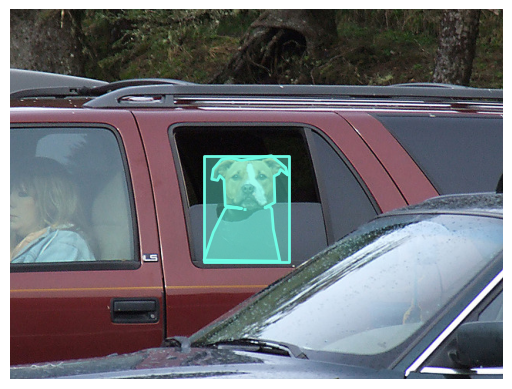

In [ ]:
# Show Image with bounding box
plt.imshow(image)
plt.axis("off")
coco.showAnns(test_image_annotations, draw_bbox=True)

In [ ]:
#  Get images containing combination of the four target classes.
target_classes = ["car", "cat", "dog", "person"]
target_classes_IDs = coco.getCatIds(catNms=target_classes)
training_images = []

for class_name in target_classes:
    # Get all images containing target class.
    print(class_name)
    training_images_categories = coco.getCatIds(catNms=class_name)
    training_images_IDs = coco.getImgIds(catIds=training_images_categories)
    training_images += coco.loadImgs(training_images_IDs)

print(f"Number of images with target classes including repetitions: {len(training_images)}.")

car
cat
dog
person
Number of images with target classes including repetitions: 569.


In [ ]:
# Filter out repeated images.
unique_training_images = []

for i in range(len(training_images)):
    if training_images[i] not in unique_training_images:
        unique_training_images.append(training_images[i])

# Shuffle the training data.
random.seed(0)
random.shuffle(unique_training_images)

print(
    f"Number of unique images in training data containing the target classes: {len(unique_training_images)}"
)

Number of unique images in training data containing the target classes: 300


{'id': 104, 'file_name': '000000007298.jpg', 'height': 480, 'width': 640, 'license': None, 'coco_url': None}


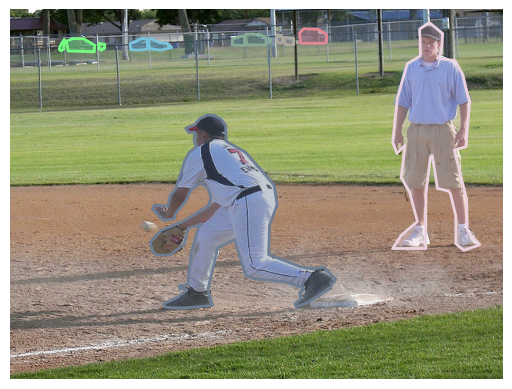

In [ ]:
# Show Annotations

training_image = unique_training_images[5]
print(training_image)

image = io.imread(f'{train_data_path}/{training_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

training_image_annotations_ID = coco.getAnnIds(
    imgIds=training_image["id"], catIds=target_classes_IDs, iscrowd=None
)
training_image_annotations = coco.loadAnns(training_image_annotations_ID)
coco.showAnns(training_image_annotations, draw_bbox=False)

plt.show()

In [ ]:
mask_example = coco.annToMask(training_image_annotations[0])
print(type(mask_example))
print(mask_example)
print(mask_example.shape)
print(np.max(mask_example))
print(np.min(mask_example))

<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(480, 640)
1
0


Unique pixel values in the mask: [0. 3.]


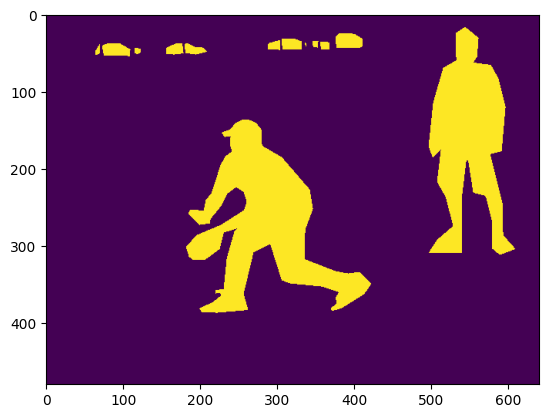

In [ ]:
mask = np.zeros((training_image["height"], training_image["width"]))

for i in range(len(training_image_annotations)):
    # Get object category name.
    object_category = get_category_name(
        training_image_annotations[i]["category_id"], categories
    )
    # Assign pixel value based on location in target_classes list.
    pixel_value = target_classes.index(object_category) + 1
    # Assign pixel value to mask based on annToMask output.
    mask = np.maximum(coco.annToMask(training_image_annotations[i]) * 3, mask)

print(f"Unique pixel values in the mask: {np.unique(mask)}")
plt.imshow(mask)
plt.show()

## U-Net Model

In [3]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, images_dir, annotation_file, class_ids, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.class_ids = class_ids
        self.num_classes = len(class_ids) + 1  # +1 for background

        with open(annotation_file, 'r') as f:
            data = json.load(f)

        self.imgs = {img['id']: img for img in data['images']}
        self.anns = {}
        for ann in data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.anns:
                self.anns[img_id] = []
            self.anns[img_id].append(ann)

        self.cat2idx = {cat_id: idx + 1 for idx, cat_id in enumerate(class_ids)}
        self.img_ids = list(self.imgs.keys())

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.imgs[img_id]
        img_path = os.path.join(self.images_dir, img_info['file_name'])

        image = Image.open(img_path).convert('RGB')
        mask = Image.new('L', (img_info['width'], img_info['height']), 0)

        anns = self.anns.get(img_id, [])
        draw = ImageDraw.Draw(mask)
        for ann in anns:
            cat_id = ann['category_id']
            if cat_id not in self.cat2idx:
                continue
            class_idx = self.cat2idx[cat_id]
            if isinstance(ann['segmentation'], list):
                for poly in ann['segmentation']:
                    if len(poly) >= 6:
                        try:
                            # Convert float coordinates to integers
                            points = [(int(poly[i]), int(poly[i+1])) for i in range(0, len(poly), 2)]
                            draw.polygon(points, fill=class_idx)
                        except ValueError:
                            print(f"Warning: Skipping invalid polygon data for image {img_id}, annotation {ann['id']}")
                            continue

        if self.transform:
            image = self.transform(image)
            _, h, w = image.shape
            mask = mask.resize((w, h), resample=Image.NEAREST)
        else:
            image = transforms.ToTensor()(image)
            mask = torch.as_tensor(np.array(mask), dtype=torch.long)

        mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        return image, mask

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(512 + 256, 256)
        self.dconv_up2 = DoubleConv(256 + 128, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        return self.conv_last(x)

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

In [6]:
def compute_metrics(preds, targets, num_classes):
    smooth = 1e-6
    preds = preds.view(-1)
    targets = targets.view(-1)

    iou = 0.0
    dice = 0.0
    acc = (preds == targets).float().mean().item()

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls

        intersection = (pred_inds & target_inds).float().sum()
        union = (pred_inds | target_inds).float().sum()
        iou += (intersection + smooth) / (union + smooth)

        dice += (2 * intersection + smooth) / (pred_inds.float().sum() + target_inds.float().sum() + smooth)

    iou /= num_classes
    dice /= num_classes

    return iou, dice, acc

def validate(model, loader, criterion, device, num_classes=4):
    model.eval()
    total_loss = 0.0
    iou_scores = []
    dice_scores = []
    pixel_accs = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            total_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            iou, dice, acc = compute_metrics(preds, masks, num_classes)

            iou_scores.append(iou)
            dice_scores.append(dice)
            pixel_accs.append(acc)

    avg_loss = total_loss / len(loader.dataset)
    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_acc = sum(pixel_accs) / len(pixel_accs)

    return avg_loss, mean_iou, mean_dice, mean_acc

In [7]:
def mean_iou(pred, target, num_classes=4):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())
    return np.nanmean(ious)

def dice_coefficient(pred, target, epsilon=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum().float()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

def pixel_accuracy(pred, target):
    correct = (pred == target).float()
    return correct.sum() / correct.numel()

In [8]:
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image = image_tensor.to(device).unsqueeze(0)
        output = model(image)
        probs = F.softmax(output, dim=1)
        mask = torch.argmax(probs, dim=1).squeeze(0)
    return mask.cpu().numpy()

In [9]:
# Define your dataset paths
train_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/train-300/data"
train_annotation = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/train-300/labels.json"
val_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/validation-300/data"
val_annotation = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/validation-300/labels.json"
test_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/test-30/data"


# COCO IDs for selected classes
classes = [41, 15, 25, 16]
class_names = ["background", "person", "cake", "dog", "car"]
num_classes = len(classes) + 1

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = CocoSegmentationDataset(train_data_path, train_annotation, classes, transform)
val_dataset = CocoSegmentationDataset(val_data_path, val_annotation, classes, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
#Unet
model_unet = UNet(num_classes).to(device)
unet_optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## Segmentation Models PyTorch UNet Model

In [11]:
# Model smp_unet
model_smp_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
)
model_smp_unet.to(device)
smp_unet_optimizer = torch.optim.Adam(model_smp_unet.parameters(), lr=1e-4)
model_smp_unet.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

#### Model Training

In [ ]:
# Unet model Train
train_losses_unet = []
val_losses_unet = []
val_ious = []
val_dices = []
val_accs = []

print("Training UNET model")
epochs = 25
for epoch in range(1, epochs + 1):
    start = time.time()
    train_loss = train_one_epoch(model_unet, train_loader, criterion, unet_optimizer, device)

    val_loss, val_iou, val_dice, val_acc = validate(model_unet, val_loader, criterion, device)

    train_losses_unet.append(train_loss)
    val_losses_unet.append(val_loss)
    val_ious.append(val_iou)

    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"IoU: {val_iou:.4f} "
          f"Time: {time.time()-start:.1f}s")

# Save model
torch.save({
    'epoch': epochs,
    'model_state_dict': model_unet.state_dict(),
    'optimizer_state_dict': unet_optimizer.state_dict(),
    'train_losses': train_losses_unet,
    'val_losses': val_losses_unet,
    'val_ious': val_ious,
    'val_accs': val_accs
}, "/content/drive/Othercomputers/My Mac/Image Segmentation/models/unet_model.pth")

Training UNET model
Epoch 1/25 | Train Loss: 0.8423 | Val Loss: 0.9113 | IoU: 0.4711 Time: 25.7s
Epoch 2/25 | Train Loss: 0.7332 | Val Loss: 0.7371 | IoU: 0.4700 Time: 25.5s
Epoch 3/25 | Train Loss: 0.6563 | Val Loss: 0.6621 | IoU: 0.4533 Time: 25.0s
Epoch 4/25 | Train Loss: 0.5998 | Val Loss: 0.6541 | IoU: 0.3281 Time: 25.0s
Epoch 5/25 | Train Loss: 0.5554 | Val Loss: 0.6072 | IoU: 0.3170 Time: 25.3s
Epoch 6/25 | Train Loss: 0.5212 | Val Loss: 0.5583 | IoU: 0.4641 Time: 25.2s
Epoch 7/25 | Train Loss: 0.4992 | Val Loss: 0.5818 | IoU: 0.4940 Time: 25.1s
Epoch 8/25 | Train Loss: 0.4782 | Val Loss: 0.5237 | IoU: 0.4652 Time: 25.2s
Epoch 9/25 | Train Loss: 0.4606 | Val Loss: 0.5097 | IoU: 0.4661 Time: 25.3s
Epoch 10/25 | Train Loss: 0.4422 | Val Loss: 0.5276 | IoU: 0.4650 Time: 25.2s
Epoch 11/25 | Train Loss: 0.4417 | Val Loss: 0.5206 | IoU: 0.4831 Time: 25.1s
Epoch 12/25 | Train Loss: 0.4218 | Val Loss: 0.5167 | IoU: 0.4773 Time: 25.3s
Epoch 13/25 | Train Loss: 0.4113 | Val Loss: 0.5389 |

In [12]:
#Load the model
unet_checkpoint = torch.load("/content/drive/Othercomputers/My Mac/Image Segmentation/models/unet_model.pth")
model_unet.load_state_dict(unet_checkpoint['model_state_dict'])
unet_optimizer.load_state_dict(unet_checkpoint['optimizer_state_dict'])
train_losses_unet = unet_checkpoint['train_losses']
val_losses_unet = unet_checkpoint['val_losses']
val_ious = unet_checkpoint['val_ious']
val_accs = unet_checkpoint['val_accs']

In [ ]:
print(val_ious)

[tensor(0.4711, device='cuda:0'), tensor(0.4700, device='cuda:0'), tensor(0.4533, device='cuda:0'), tensor(0.3281, device='cuda:0'), tensor(0.3170, device='cuda:0'), tensor(0.4641, device='cuda:0'), tensor(0.4940, device='cuda:0'), tensor(0.4652, device='cuda:0'), tensor(0.4661, device='cuda:0'), tensor(0.4650, device='cuda:0'), tensor(0.4831, device='cuda:0'), tensor(0.4773, device='cuda:0'), tensor(0.4881, device='cuda:0'), tensor(0.4977, device='cuda:0'), tensor(0.5148, device='cuda:0'), tensor(0.5157, device='cuda:0'), tensor(0.4923, device='cuda:0'), tensor(0.4929, device='cuda:0'), tensor(0.5101, device='cuda:0'), tensor(0.4713, device='cuda:0'), tensor(0.4971, device='cuda:0'), tensor(0.4996, device='cuda:0'), tensor(0.5032, device='cuda:0'), tensor(0.4864, device='cuda:0'), tensor(0.4790, device='cuda:0')]
[]


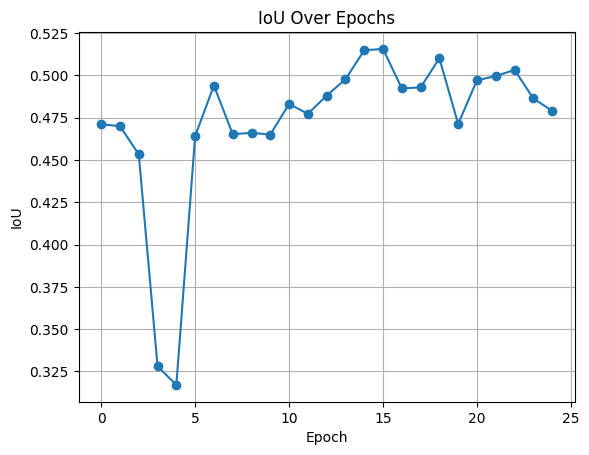

In [ ]:
def plot_metrics(values, title, ylabel):
    values = [v.cpu().item() if isinstance(v, torch.Tensor) else v for v in values]
    plt.plot(values, marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Usage
plot_metrics(val_ious, 'IoU Over Epochs', 'IoU')

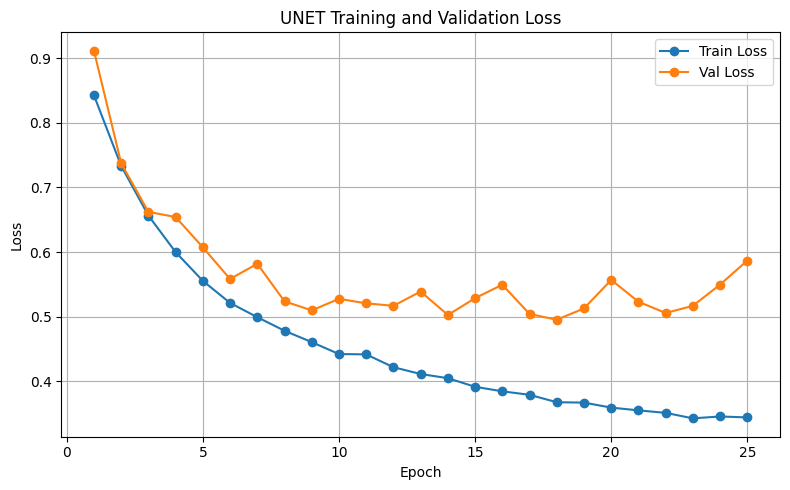

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, unet_checkpoint['epoch'] + 1), train_losses_unet, label='Train Loss', marker='o')
plt.plot(range(1, unet_checkpoint['epoch'] + 1), val_losses_unet, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("UNET Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Train Smp UNET model
train_losses_unet_smp = []
val_losses_unet_smp = []
val_ious_unet_smp = []
val_dices_unet_smp = []
val_accs_unet_smp = []

print("Training smp UNET model")
epochs = 25
for epoch in range(1, epochs + 1):
    start = time.time()
    train_loss = train_one_epoch(model_smp_unet, train_loader, criterion, smp_unet_optimizer, device)
    val_loss, val_iou, val_dice, val_acc = validate(model_smp_unet, val_loader, criterion, device)
    train_losses_unet_smp.append(train_loss)
    val_losses_unet_smp.append(val_loss)
    val_ious_unet_smp.append(val_iou)
    val_dices_unet_smp.append(val_dice)
    val_accs_unet_smp.append(val_acc)
    print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"IoU: {val_iou:.4f} "
          f"Time: {time.time()-start:.1f}s")

Training smp UNET model
Epoch 1/25 | Train Loss: 0.7419 | Val Loss: 0.6502 | IoU: 0.3119 Time: 181.6s
Epoch 2/25 | Train Loss: 0.5154 | Val Loss: 0.5157 | IoU: 0.3302 Time: 14.9s
Epoch 3/25 | Train Loss: 0.3966 | Val Loss: 0.4765 | IoU: 0.5218 Time: 14.8s
Epoch 4/25 | Train Loss: 0.3334 | Val Loss: 0.4134 | IoU: 0.5838 Time: 14.7s
Epoch 5/25 | Train Loss: 0.2808 | Val Loss: 0.4301 | IoU: 0.5914 Time: 14.6s
Epoch 6/25 | Train Loss: 0.2482 | Val Loss: 0.4413 | IoU: 0.5635 Time: 14.5s
Epoch 7/25 | Train Loss: 0.2142 | Val Loss: 0.4218 | IoU: 0.5847 Time: 14.6s
Epoch 8/25 | Train Loss: 0.1889 | Val Loss: 0.4740 | IoU: 0.5965 Time: 14.8s
Epoch 9/25 | Train Loss: 0.1680 | Val Loss: 0.4148 | IoU: 0.6031 Time: 14.7s
Epoch 10/25 | Train Loss: 0.1492 | Val Loss: 0.4324 | IoU: 0.6005 Time: 14.7s
Epoch 11/25 | Train Loss: 0.1390 | Val Loss: 0.4555 | IoU: 0.6052 Time: 14.7s
Epoch 12/25 | Train Loss: 0.1352 | Val Loss: 0.5150 | IoU: 0.5895 Time: 14.7s
Epoch 13/25 | Train Loss: 0.1372 | Val Loss: 0.5

In [ ]:
# Save the model
torch.save({
    'epoch': epochs,
    'model_state_dict': model_smp_unet.state_dict(),
    'optimizer_state_dict': smp_unet_optimizer.state_dict(),
    'train_losses': train_losses_unet_smp,
    'val_losses': val_losses_unet_smp,
    'val_ious': val_ious_unet_smp,
    'val_accs': val_accs_unet_smp
}, "/content/drive/Othercomputers/My Mac/Image Segmentation/models/smp_unet_model.pth")

In [13]:
#Load the model
smp_unet_checkpoint = torch.load("/content/drive/Othercomputers/My Mac/Image Segmentation/models/smp_unet_model.pth")
model_smp_unet.load_state_dict(smp_unet_checkpoint['model_state_dict'])
smp_unet_optimizer.load_state_dict(smp_unet_checkpoint['optimizer_state_dict'])
train_losses_unet_smp = smp_unet_checkpoint['train_losses']
val_losses_unet_smp = smp_unet_checkpoint['val_losses']

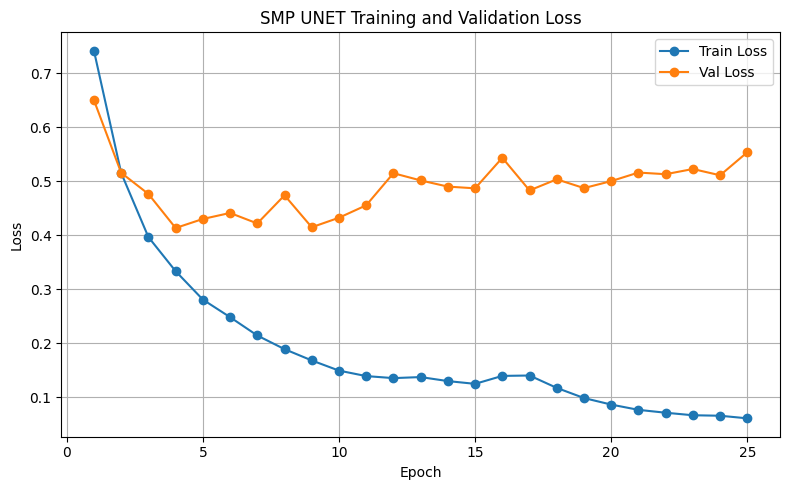

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, smp_unet_checkpoint['epoch'] + 1), train_losses_unet_smp, label='Train Loss', marker='o')
plt.plot(range(1, smp_unet_checkpoint['epoch'] + 1), val_losses_unet_smp, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SMP UNET Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

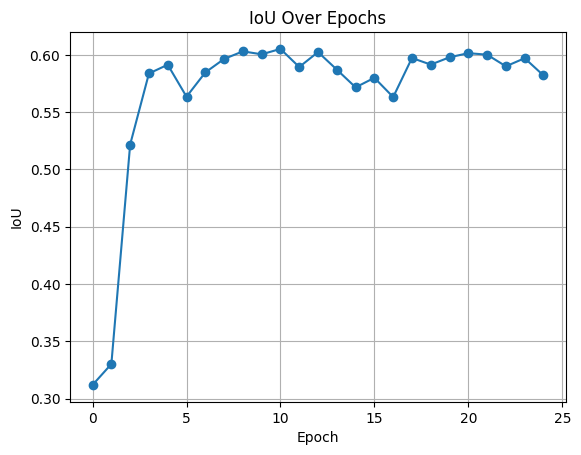

In [ ]:
plot_metrics(val_ious_unet_smp, 'IoU Over Epochs', 'IoU')

Processing image: /content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/test-30/000000001494.jpg


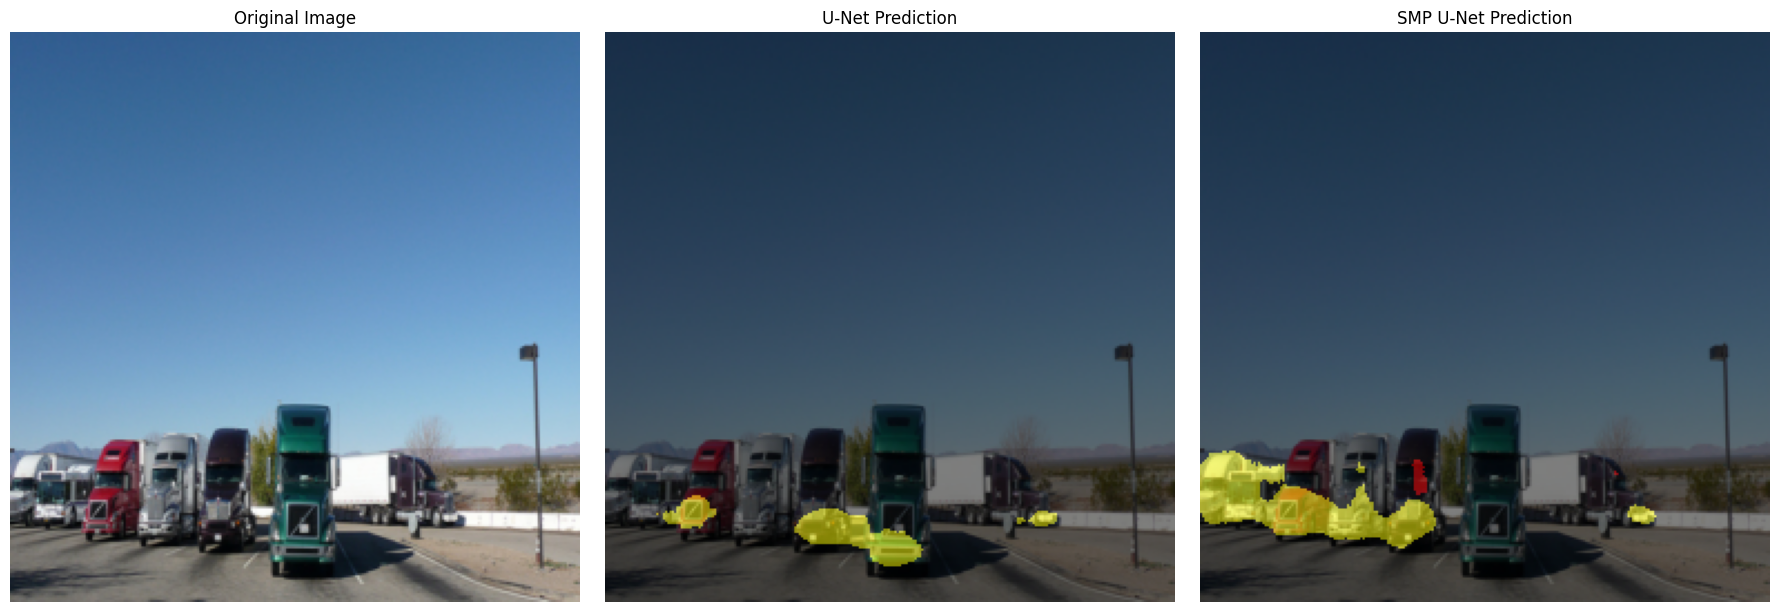

Processing image: /content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/test-30/000000001643.jpg


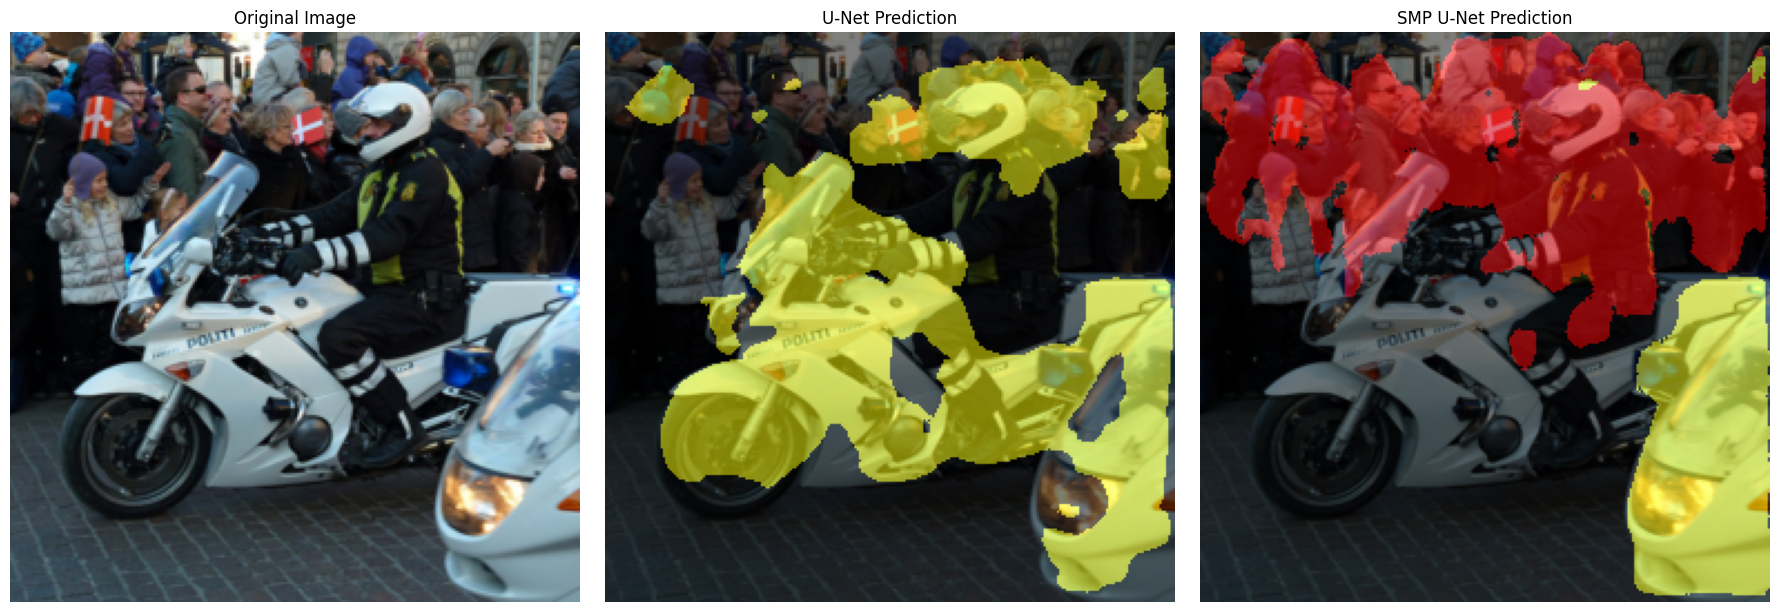

Processing image: /content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/test-30/000000001385.jpg


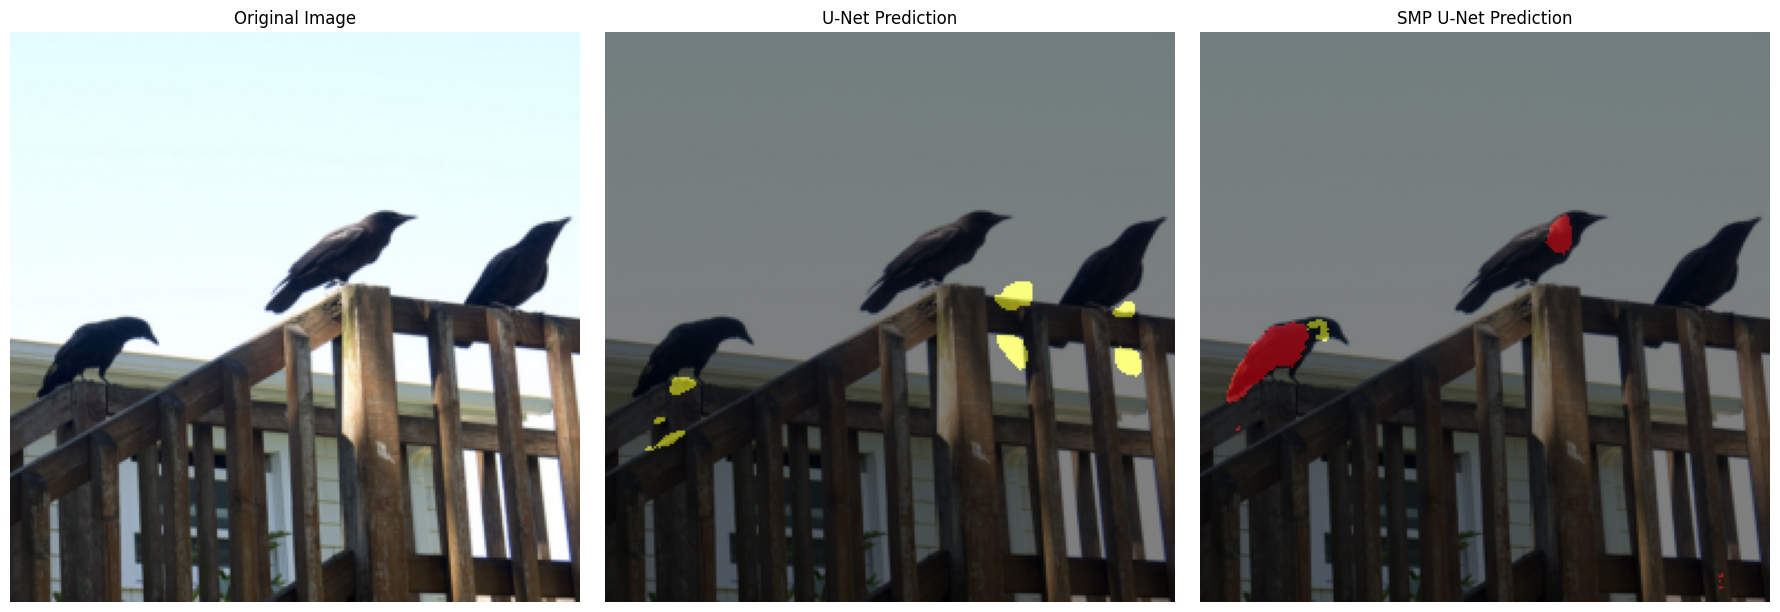

Processing image: /content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/test-30/000000001551.jpg


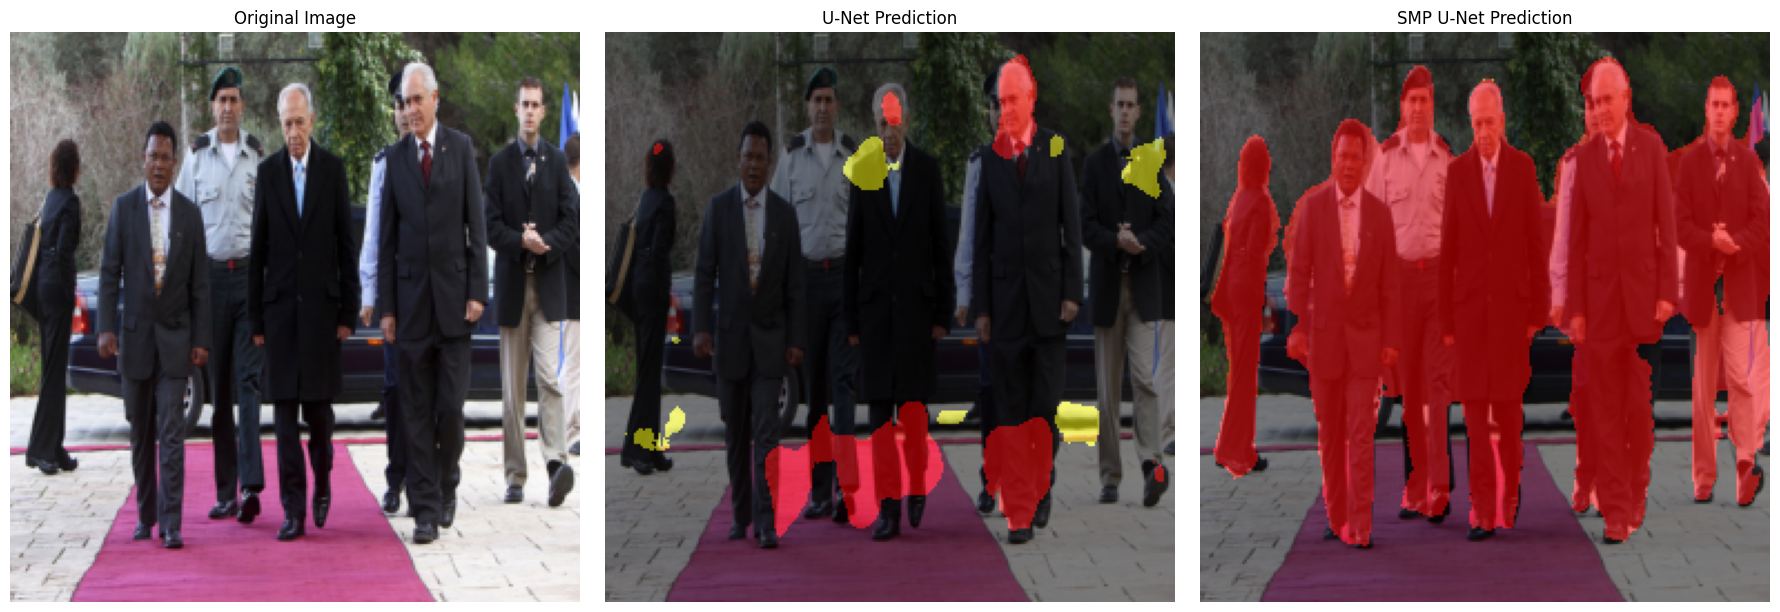

Processing image: /content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/test-30/000000001773.jpg


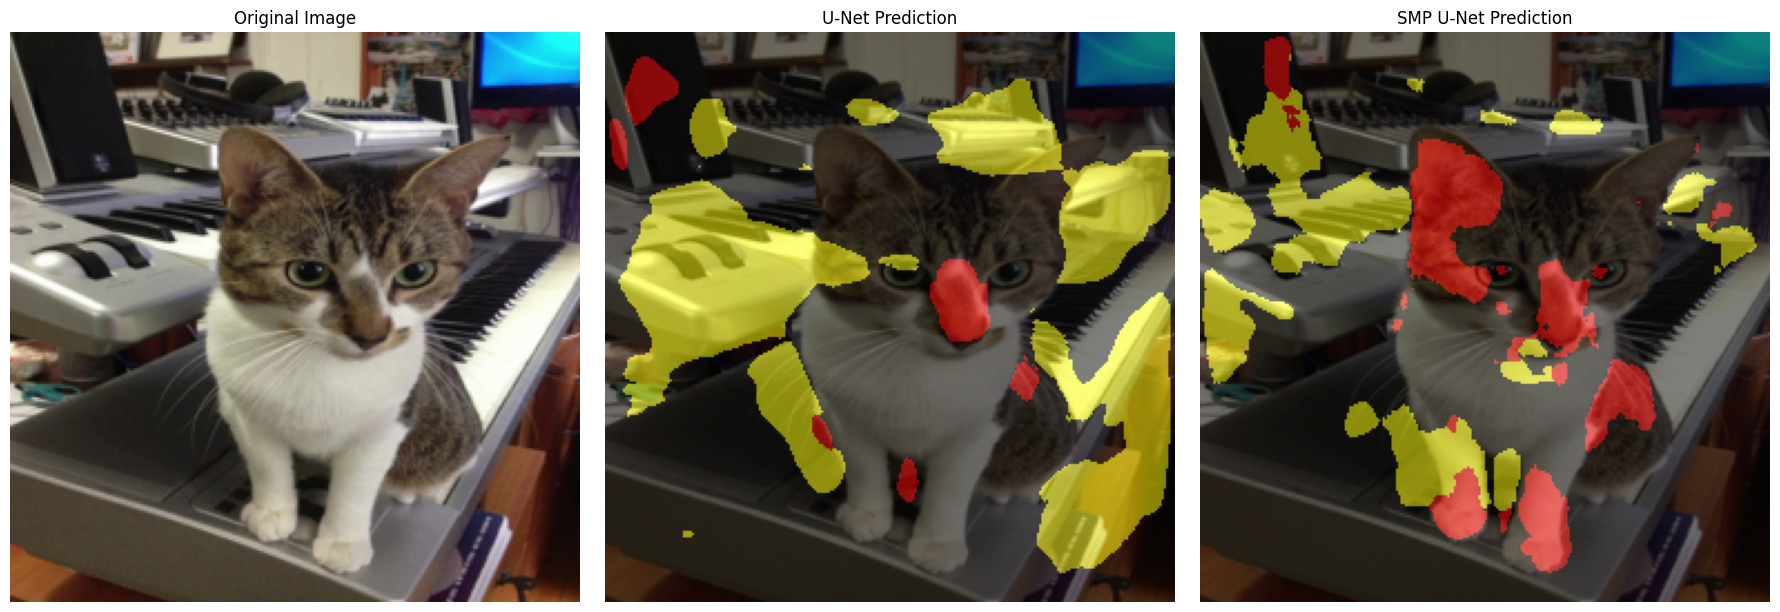

In [14]:
#Plot Image predictions

class_labels = {
    1: "person",
    2: "cake",
    3: "dog",
    4: "cat"
}

colormap = {
    1: (255, 0, 0),     # person
    2: (0, 255, 0),     # cake
    3: (0, 0, 255),     # dog
    4: (255, 255, 0),   # cat
}

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def predict_mask(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    return pred_mask

def overlay_mask(image_tensor, mask, alpha=0.5):
    image = image_tensor.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)

    mask_rgb = np.zeros_like(image)
    for class_id, color in colormap.items():
        mask_rgb[mask == class_id] = color

    overlay = ((1 - alpha) * image + alpha * mask_rgb).astype(np.uint8)
    return overlay

def visualize_comparison(image_path, model_unet, model_smp_unet, device):
    image = Image.open(image_path).convert("RGB")
    image_tensor = test_transform(image)

    # Get predictions from both models
    unet_mask = predict_mask(model_unet, image_tensor, device)
    smp_mask = predict_mask(model_smp_unet, image_tensor, device)

    # Generate overlay visuals
    original = (image_tensor.permute(1, 2, 0) * 255).byte().numpy()
    unet_overlay = overlay_mask(image_tensor, unet_mask)
    smp_overlay = overlay_mask(image_tensor, smp_mask)

    # Plot
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(unet_overlay)
    plt.title("U-Net Prediction")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(smp_overlay)
    plt.title("SMP U-Net Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

#test images
test_data_path = "/content/drive/Othercomputers/My Mac/Image Segmentation/dataset/images/test-30/"
test_images = [os.path.join(test_data_path, fname) for fname in os.listdir(test_data_path) if fname.endswith((".png", ".jpg", ".jpeg"))]

# Visualize
for img_path in test_images[:5]:
    print(f"Processing image: {img_path}")
    visualize_comparison(img_path, model_unet, model_smp_unet, device)